Koriscen je dataset: http://www.mfdemirci.etu.edu.tr/Etu10Silhouette.rar

In [1]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from scipy.spatial import distance
import imageio
import cv2
import pickle

In [2]:
# funkcija koja izdvaja feature-e za pojedinacne slike
def image_features(image_path, vector_size=128): # vector_size predstavlja broj keypoint-a koje cemo da razmatramo
    image = imageio.imread(image_path, pilmode="RGB") # ucitavamo prosledjenu sliku
    try:
        
        surf = cv2.xfeatures2d.SURF_create() # kreiramo surf objekat koji je dobar za rad sa mutnim i rotiranim, ali ne i sa 
                                             # slikama koje su nasatale iz razlicitih uglova ili cije se osvetljenje menja
        
        surf.setHessianThreshold(500) # surf koristi Hessian corner detector za nalazenje keypoint-a, pa zadajemo treshold
                                      # koji predstavlja koliki mora biti izlaz Hessian filtera da bi se tacka smatrala jednom od
                                      # keypoint-a; sto je treshold veci, dobicemo manje keypoint-a, ali ce one biti bitnije
                                      # za treshold 500 se dobijaju najprecizniji rezultati: https://www.researchgate.net/figure/Relation-between-hessian-threshold-value-and-Accuracy-of-SURF-detector-As-shown-in_fig2_309363445
        
        surf.setUpright(True) # kad je True, racuna se i orijentacija i sporije je, ali preciznije
        
        surf.setExtended(True) # kad je True onda je duzina vektora deskriptora 128 umesto 64 i to daje vise feature-a
        
        keypoints = surf.detect(image) # nalazimo keypoints slike
        keypoints = sorted(keypoints, key=lambda x: -x.response)[:vector_size] # sortiramo ih opadajuce po povratnim vrednostima keypoint-a i
                                                                               # od zadrzavamo samo prvih/najboljih vector_size
      
        keypoints, features = surf.compute(image, keypoints) # racunamo deskriptore (feature-e) za keypoint-e koje smo vec nasli
        
        # keypoints, features = sift.detectAndCompute(image) # moglo je i u jednom koraku sve ovako
        
        features = features.flatten() # feature-e spakujemo u jedan vektor feature-a (jednodimenzioni) jer je inace dimenzije 
                            # vector_size x 128, u nasem slucaju, zbog podesavanja sa pocetka bloka je bas 128, inace bi bilo 64
                            # dakle dsc je bila matrica cije su vrste prestavljale feature-e pojedinacnih keypoint-a
        
        # u slucaju da smo zadali vector_size veci od podrazumevanog, dobijeni vektor feature-a dopunimo nulama do odgovarajuce duzine
        needed_size = (vector_size * 128)
        if features.size < needed_size:
            features = np.concatenate([features, np.zeros(needed_size - features.size)])

    except cv2.error as e:
        print('Error: ', e)
        return None

    return features # ova funkcija vraca vektor feature-a za zadatu sliku

In [3]:
# funkcija koja izdvaja feature-e svih slika naseg dataset-a u fajl
def dataset_features(dataset_path, pickled_features_path):
    images = [os.path.join(dataset_path, i) for i in sorted(os.listdir(dataset_path))] # izlistamo slike dataset-a
 
    # ukliko neki od fajlova dataset-a ne bude slika odgovarajuceg formata (za sad samo .bmp, .jpg i .png), izbacimo ga
    for i in images[:]:
        if not(i.endswith(".bmp") or i.endswith(".jpg") or i.endswith(".png")):
            images.remove(i)
           
    # vrsi se izdvajanje feature-a svih slika
    result = {}
    for i in images:
        name = i.split('/')[-1].lower()
        result[name] = image_features(i)
    
    # cuvamo rezultate u .pck fajlu - objekte konvertujemo u byte stream (Pickling)
    with open(pickled_features_path, "wb") as fp:
        pickle.dump(result, fp)

In [4]:
# funkcija koja nalazi top_n najslicnjih slika
def match_images(_query_image_path, pickled_features_path, top_n):
    # vrsimo ucitavanje (Unpickling podataka) - iz byte stream-a u pocetne objekte
    with open(pickled_features_path, "rb") as fp:
        data = pickle.load(fp)
    
    # stavljamo imena svih slika naseg dataset-a u names, a feature-e u matrix
    names = []
    matrix = []
    for k, v in data.items():
        names.append(k)
        matrix.append(v)
    
    # transformisemo ih u np matrice
    matrix = np.array(matrix)
    names = np.array(names)
    
    features = image_features(query_image_path).reshape(1, -1) # racunamo feature-e trazene slike
    
    distances = distance.cdist(matrix, features, 'cosine').reshape(-1) # racunamo rastojanja feature-a trazene slike od svih ostalih
                                                                       # 'euclidean' bi trebalo da radi dobro za SURF, ali ovo deluje bolje
    nearest_ids = np.argsort(distances)[: top_n].tolist() # argsort daje indekse u poretku u kome bi bili da je sortirano
    
    nearest_paths = names[nearest_ids].tolist() # imena top_n najslicnijih slika

    return nearest_paths, distances[nearest_ids].tolist()

In [5]:
# samo pomocna funkcija za prikaz slika
def show_image(path):
    image = imageio.imread(path, pilmode="RGB")
    plt.imshow(image)
    plt.show()

In [11]:
def search_images(query_image_path, dataset_path, pickled_features_path, top_n):
    print ('Query image ==========================================')
    show_image(query_image_path)
        
    print ('Extracting features from images...')
    dataset_features(dataset_path, pickled_features_path)
    
    names, match = match_images(query_image_path, pickled_features_path, top_n) # hocemo da nadjemo 100 slika najslicnijih trazenoj
    
    # prikazemo najboljih 100 slika
    print ('Result images ========================================')
    for i in range(top_n):
        print ('Match %s' % (1-match[i]))
        show_image(os.path.join(dataset_path, names[i]))

Query image ==========================================


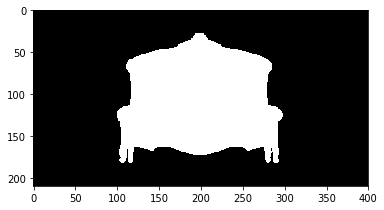

Extracting features from images...
Result images ========================================
Match 1.0


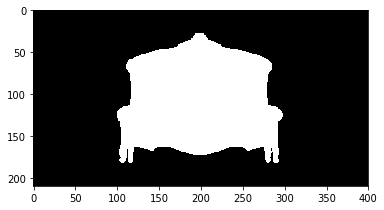

Match 0.28164847982733143


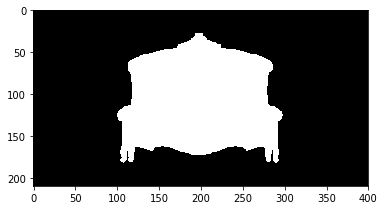

Match 0.2595074051358952


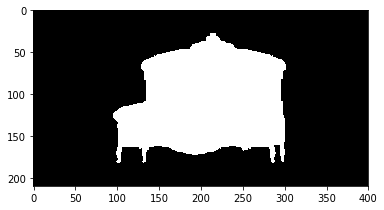

Match 0.25633450568018357


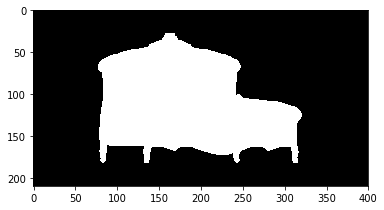

Match 0.2529686269542428


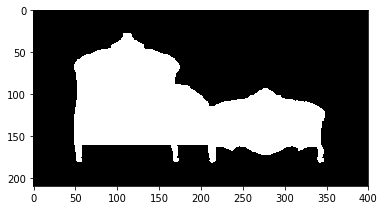

Match 0.23729073920657084


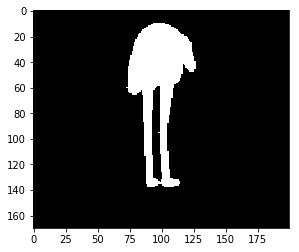

Match 0.23488839988957033


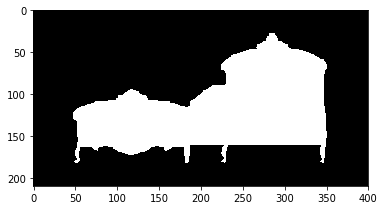

Match 0.23074110684022886


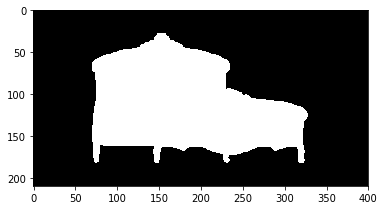

Match 0.22959155240837903


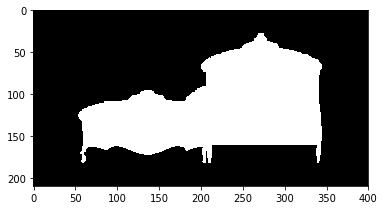

Match 0.2283568073990847


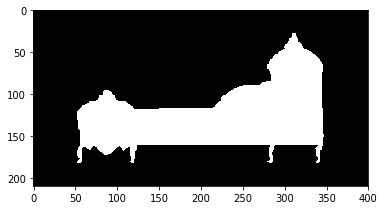

Match 0.22777407525618099


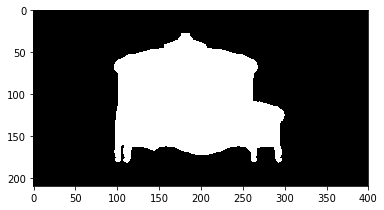

Match 0.22669123273106528


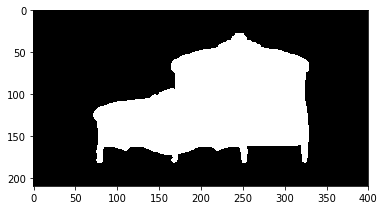

Match 0.22389000083498112


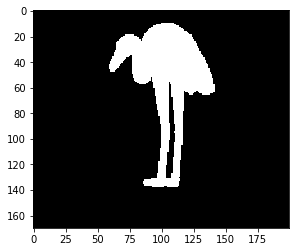

Match 0.22368239558857783


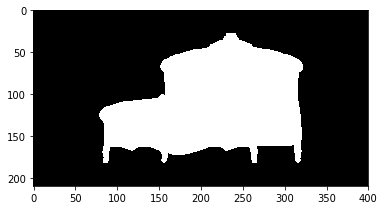

Match 0.22331695088461578


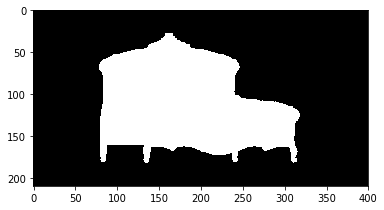

Match 0.22290715657249693


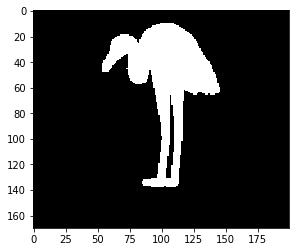

Match 0.22264934388405133


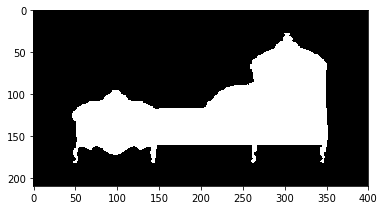

Match 0.22148609185748613


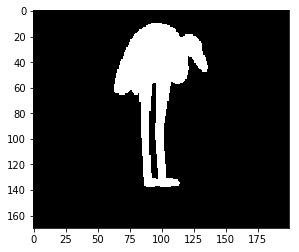

Match 0.22058607964580035


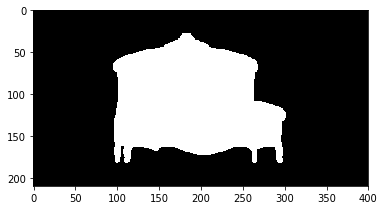

Match 0.22035313357427544


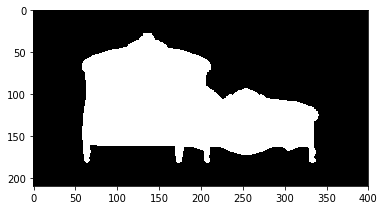

Match 0.22001537950770644


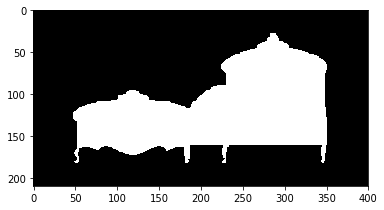

Match 0.21977401538810537


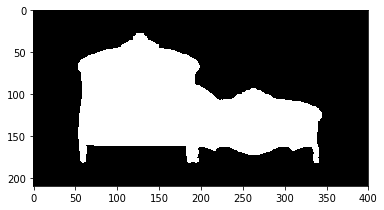

Match 0.2175817658143111


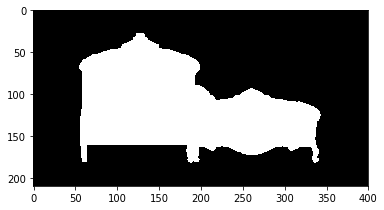

Match 0.21570489295605588


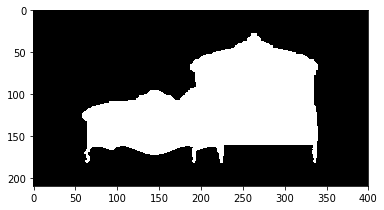

Match 0.21556980287064853


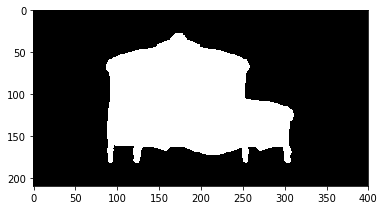

Match 0.21232729187802246


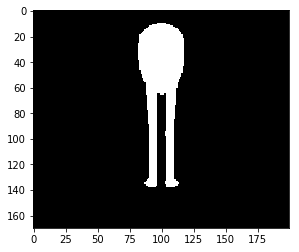

Match 0.21214709668137632


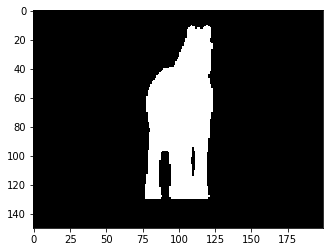

Match 0.21182076689011164


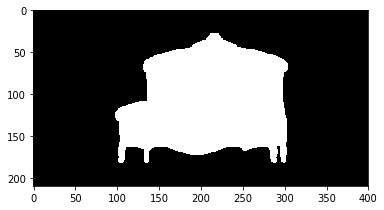

Match 0.20994074951682928


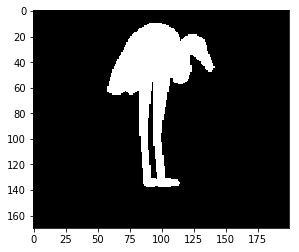

Match 0.20895940766891863


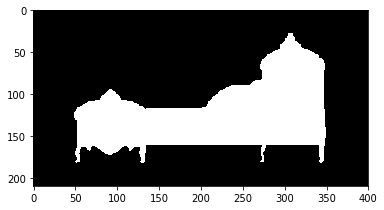

Match 0.2081407802246802


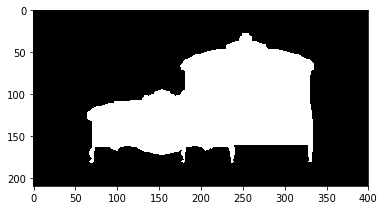

Match 0.207049247460812


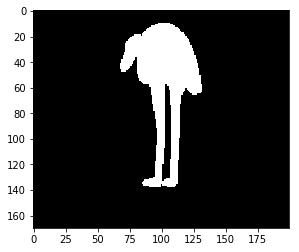

Match 0.2060283708676952


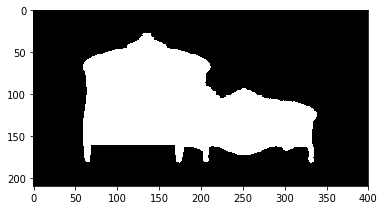

Match 0.20509510411694487


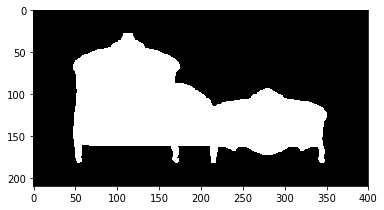

Match 0.20465391413738288


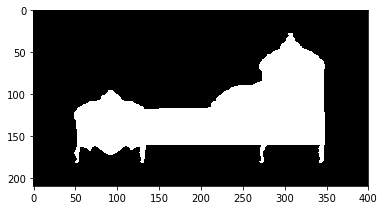

Match 0.20386620003140943


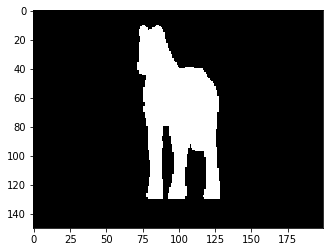

Match 0.203223314264661


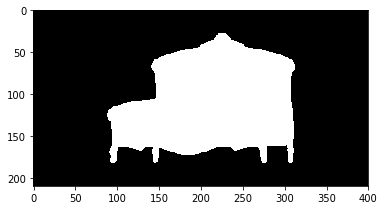

Match 0.20309637053692808


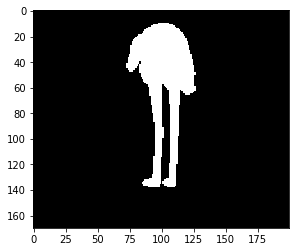

Match 0.20254404080238197


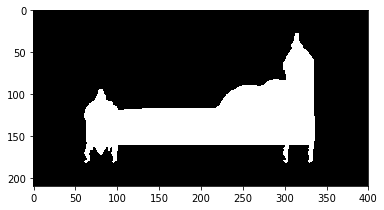

Match 0.20167726385881857


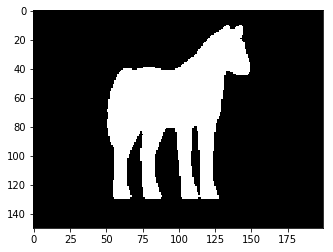

Match 0.20099010674797335


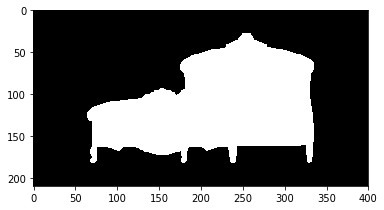

Match 0.20095259113564357


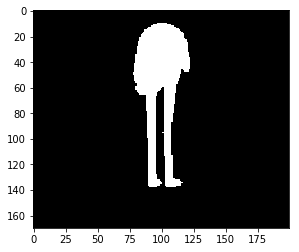

Match 0.2008661647658817


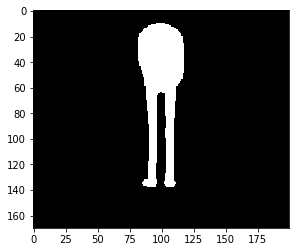

Match 0.20086381500372075


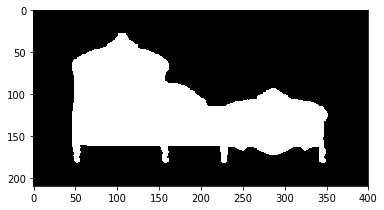

Match 0.20081370548496347


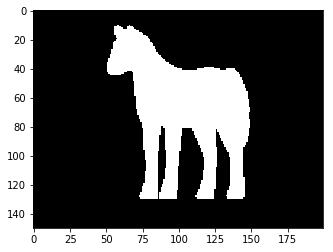

Match 0.20069453264088533


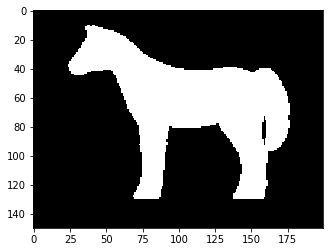

Match 0.2005384341828691


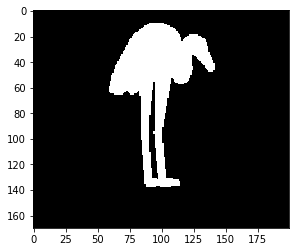

Match 0.2003610812804535


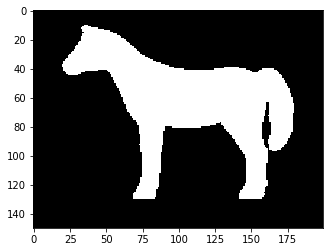

Match 0.19971570946766704


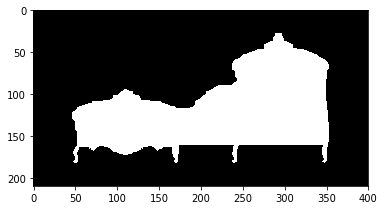

Match 0.1997142439216233


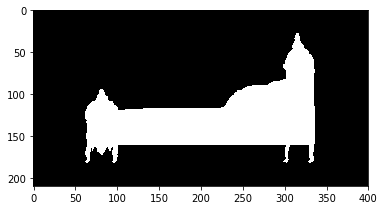

Match 0.1992942100083427


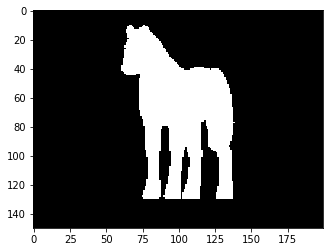

Match 0.19872049529663505


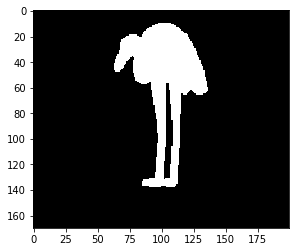

Match 0.19869824422559257


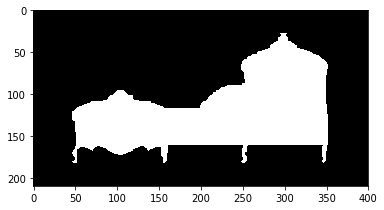

Match 0.1985445205783527


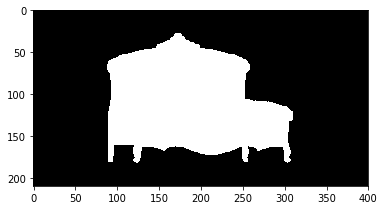

Match 0.19787754591279172


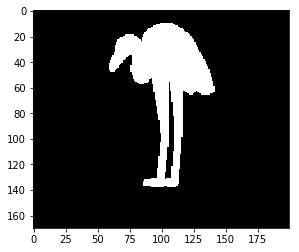

Match 0.19750543826843214


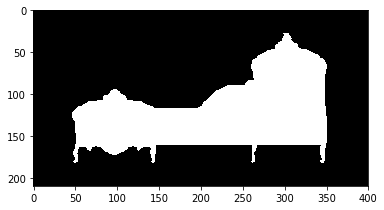

Match 0.1959334246390375


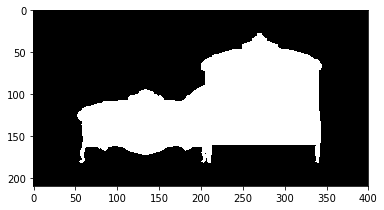

Match 0.19476120364521898


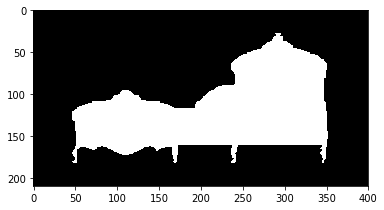

Match 0.19423469777112334


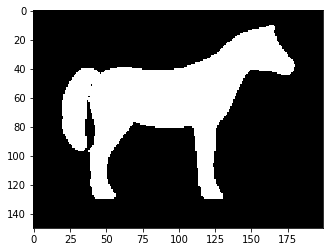

Match 0.1941758112022236


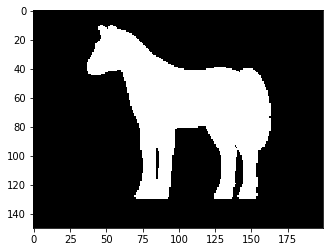

Match 0.19364145205356076


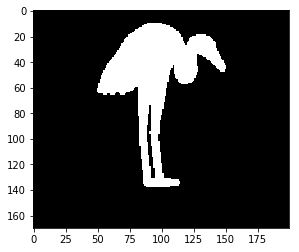

Match 0.19339120108920227


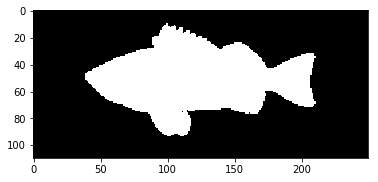

Match 0.19329796543254962


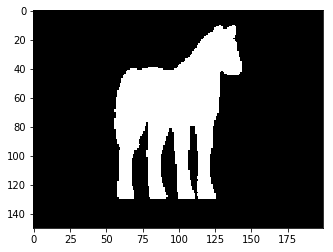

Match 0.19283226991727453


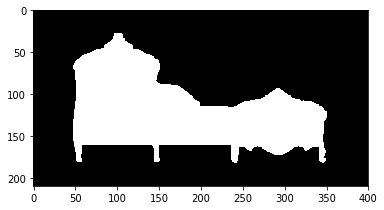

Match 0.19272833904229036


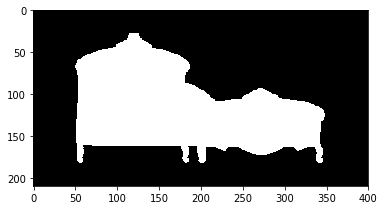

Match 0.1921726923068522


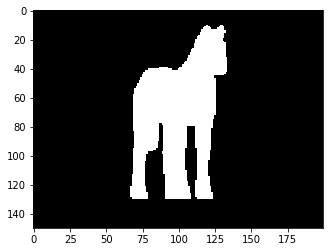

Match 0.1920819764042977


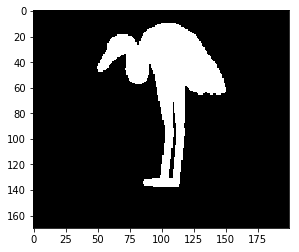

Match 0.19195148878432722


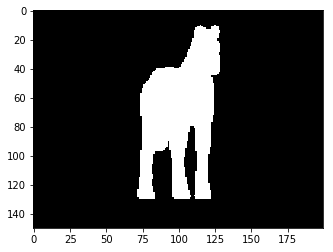

Match 0.1919432529304138


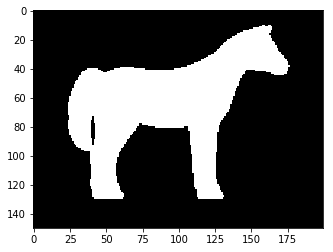

Match 0.19174838956571494


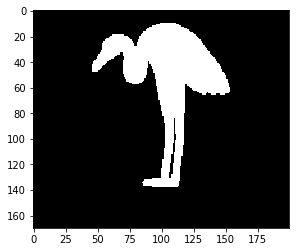

Match 0.19131638103890192


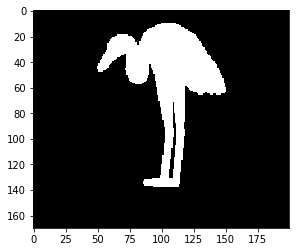

Match 0.19127192002700455


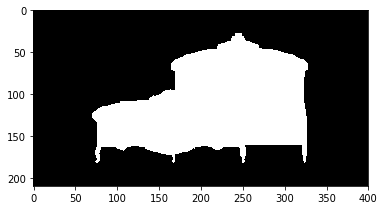

Match 0.19114968003613686


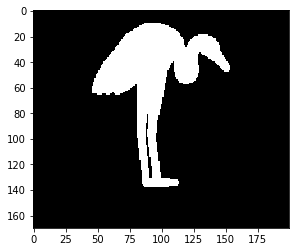

Match 0.19112360289100705


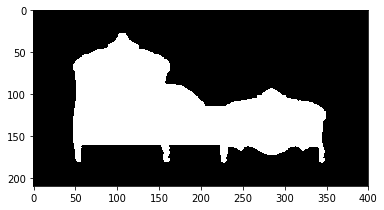

Match 0.19095068386796776


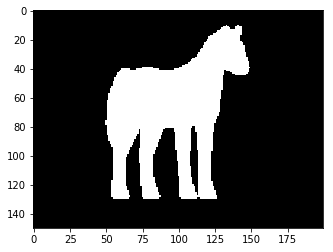

Match 0.19087172424212773


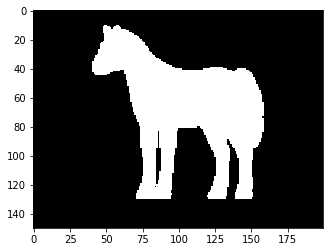

Match 0.19076554121563272


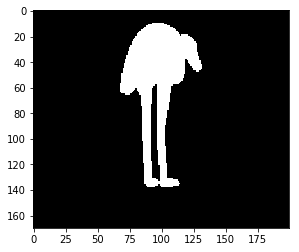

Match 0.1906261335472068


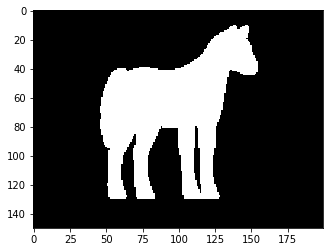

Match 0.19024399061044273


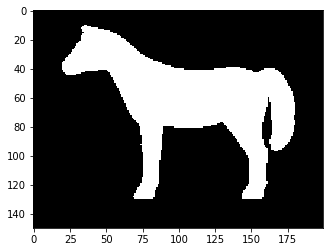

Match 0.19015561022870298


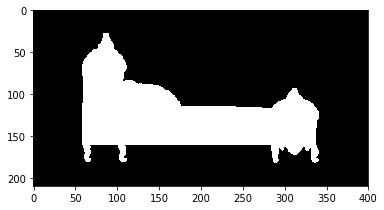

Match 0.19008745804879446


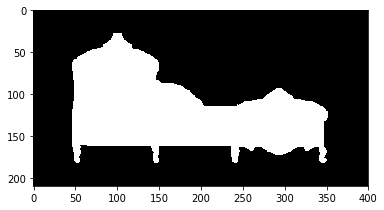

Match 0.18955447226575894


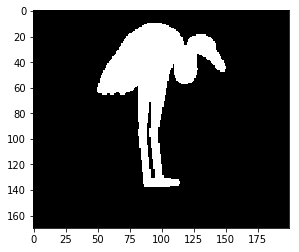

Match 0.18952674406134018


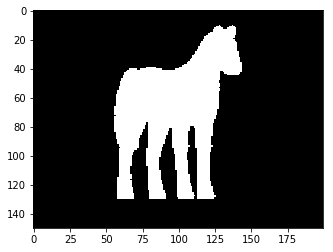

Match 0.1895008847971954


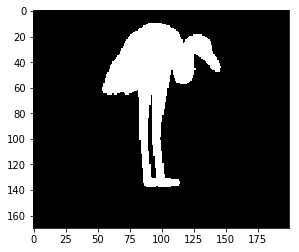

Match 0.1893427341078744


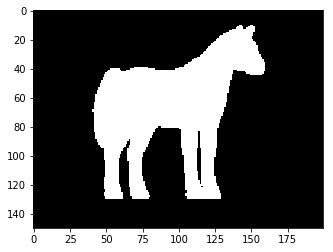

Match 0.18921026069662084


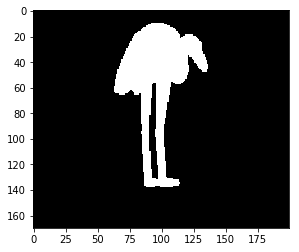

Match 0.18800971846572023


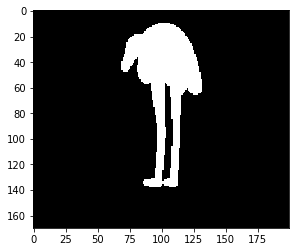

Match 0.18681150747728326


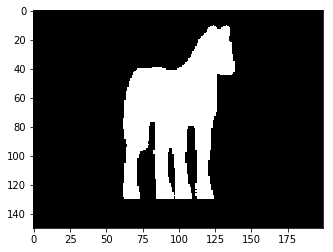

Match 0.1862908064239508


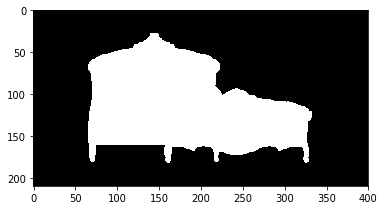

Match 0.18585639523686337


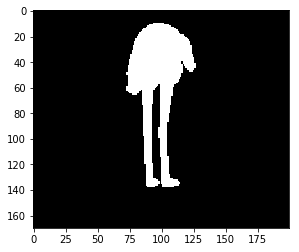

Match 0.1856042472910293


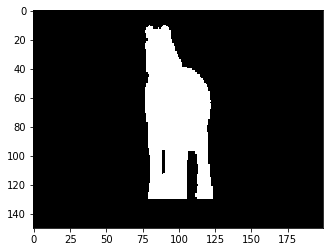

Match 0.1852318583799979


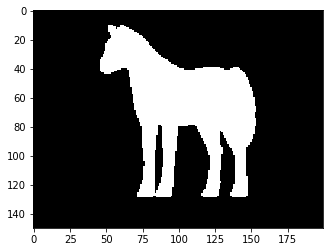

Match 0.1851518868572255


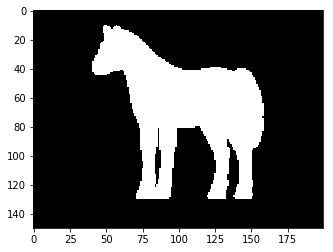

Match 0.18483755930055223


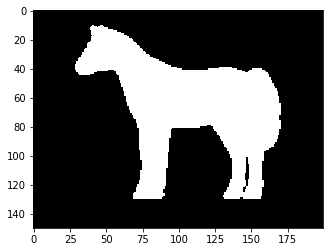

Match 0.18455842403359968


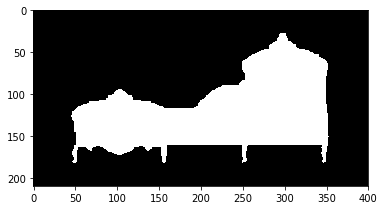

Match 0.18285036044819813


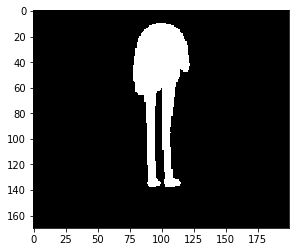

Match 0.18264707999131646


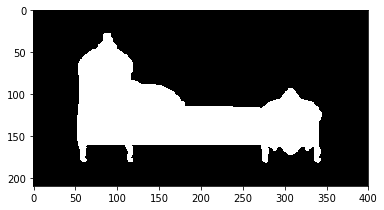

Match 0.18214517115014806


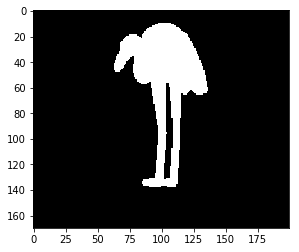

Match 0.181947212841703


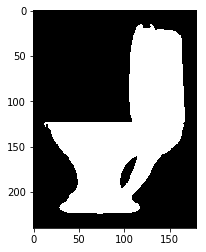

Match 0.1815295707406468


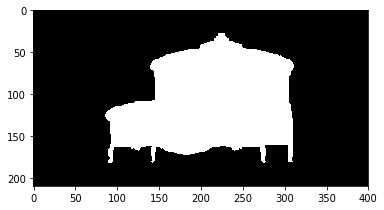

In [12]:
dataset_path = 'slike/'
query_image_path = 'slike/bed000.bmp'
pickled_features_path = 'features.pck'
top_n = 100

search_images(query_image_path, dataset_path, pickled_features_path, top_n)